# MUTI CLASIFICATION LUNG

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from transformers import ViTForImageClassification, ViTFeatureExtractor, ViTConfig
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torch import device
from torchvision import transforms

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

/media/rafihaqul/FC86902B868FE50C/Documents/AMIKOM/skripsi/project_1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## LOAD DATASET

In [2]:
# Load train and validation data
train_df = pd.read_csv('CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv('CheXpert-v1.0-small/valid.csv')

if 'train_df' in locals() and 'valid_df' in locals():
    print("dataset loaded")
else:
    print("fail load dataset")

dataset loaded


In [3]:
# Display first 5 rows of validation data
train_df.tail()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
223409,CheXpert-v1.0-small/train/patient64537/study2/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN
223410,CheXpert-v1.0-small/train/patient64537/study1/...,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN
223411,CheXpert-v1.0-small/train/patient64538/study1/...,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223412,CheXpert-v1.0-small/train/patient64539/study1/...,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0
223413,CheXpert-v1.0-small/train/patient64540/study1/...,Female,0,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [4]:
train_df.describe()

,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,223414.000000,22381.0,44839.000000,46203.000000,117778.000000,11944.000000,85956.000000,70622.000000,27608.000000,68443.000000,78934.000000,133211.000000,6492.000000,12194.000000,123217.000000
mean,60.430653,1.0,-0.035795,0.409346,0.848911,0.644508,0.456769,-0.183498,-0.461134,-0.005304,0.206540,0.559706,0.134011,0.688699,0.932680
std,17.820925,0.0,0.718442,0.769323,0.472571,0.691607,0.741785,0.753980,0.828249,0.990244,0.493529,0.648859,0.966183,0.565435,0.283377
min,0.000000,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,49.000000,1.0,-1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,1.000000
50%,62.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,74.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Cetak jumlah data unik pada setiap kolom di train_df (kecuali 'Path')
print("Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):")
unique_counts = train_df.loc[:, ~train_df.columns.isin(['Path'])].nunique()
unique_values = train_df.loc[:, ~train_df.columns.isin(['Path'])].apply(lambda x: [str(val) for val in x.unique()])
result = pd.DataFrame({'Unique Count': unique_counts, 'Unique Values': unique_values.apply(lambda x: ', '.join(x))})
print(result)


Jumlah data unik pada setiap kolom di train_df (kecuali 'Path'):
                            Unique Count  \
Sex                                    3   
Age                                   74   
Frontal/Lateral                        2   
AP/PA                                  4   
No Finding                             1   
Enlarged Cardiomediastinum             3   
Cardiomegaly                           3   
Lung Opacity                           3   
Lung Lesion                            3   
Edema                                  3   
Consolidation                          3   
Pneumonia                              3   
Atelectasis                            3   
Pneumothorax                           3   
Pleural Effusion                       3   
Pleural Other                          3   
Fracture                               3   
Support Devices                        3   

                                                                Unique Values  
Sex               

### Check nilai ambigu (-1.0)

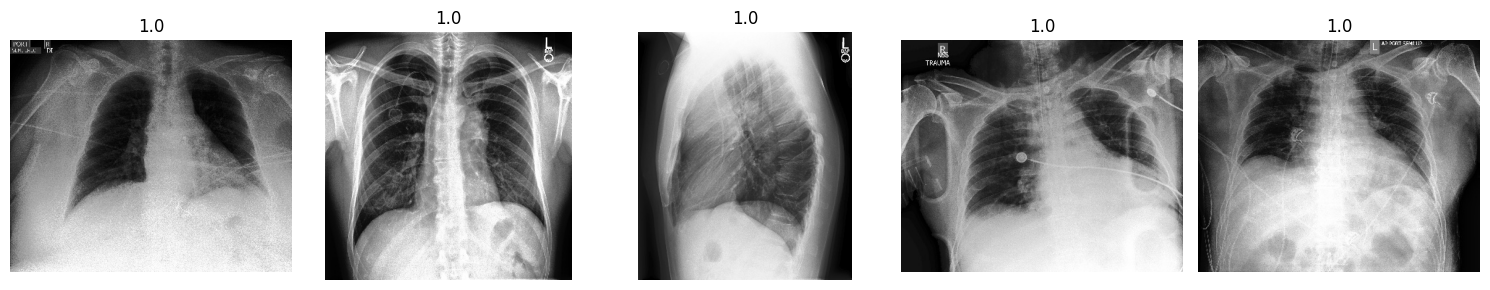

In [6]:
# Ambil 5 baris dari train_df yang label 'Support Devices' bernilai -1.0
support_device_neg1 = train_df[train_df['Support Devices'] == 1.0].head(5)

plt.figure(figsize=(15, 3))
for i, (_, row) in enumerate(support_device_neg1.iterrows()):
    img_path = row['Path']
    image = Image.open(img_path).convert('RGB')
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"{row['Support Devices']}")
plt.tight_layout()
plt.show()

>Dari hasil penelitian diatas bahwa uncurtain (-1.0) pada `'Support Devices'` cenderung positive (1.0). peneliti melabeli uncertain karena bahwa kondisi yang ada digambar tidak tampak terlihat jelas

### Check imbalance data

In [7]:
# Ubah semua nilai -1.0 menjadi 1.0 pada kolom label di train_df dan valid_df
label_cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

imbalance_check_train = train_df[label_cols].replace(-1.0, 1.0)
imbalance_check_valid = valid_df[label_cols].replace(-1.0, 1.0)

Distribusi Label:
No Finding                     22419
Enlarged Cardiomediastinum     23310
Cardiomegaly                   35155
Lung Opacity                  111305
Lung Lesion                    10675
Edema                          65275
Consolidation                  42558
Pneumonia                      24817
Atelectasis                    67195
Pneumothorax                   22601
Pleural Effusion               97882
Pleural Other                   6177
Fracture                        9682
Support Devices               117187
dtype: int64

Rasio Imbalance: 18.97
Label paling banyak: Support Devices dengan 117187 kemunculan
Label paling sedikit: Pleural Other dengan 6177 kemunculan


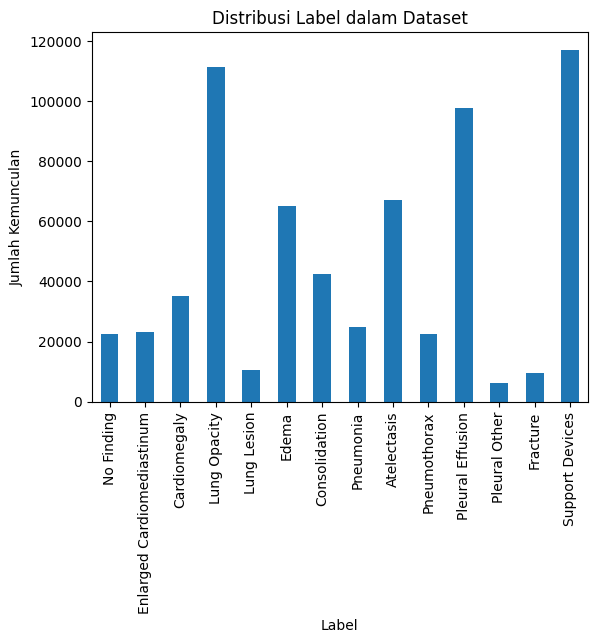

In [8]:
# Ambil 14 label terakhir dari kolom train_df dan valid_df, hitung distribusi label (jumlah 1.0)
train_label_counts = (imbalance_check_train == 1.0).sum()
valid_label_counts = (imbalance_check_valid == 1.0).sum()
label_counts = train_label_counts + valid_label_counts

print("Distribusi Label:")
print(label_counts)

max_count = label_counts.max()
min_count = label_counts.min()
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\nRasio Imbalance: {imbalance_ratio:.2f}")
print(f"Label paling banyak: {label_counts.idxmax()} dengan {max_count} kemunculan")
print(f"Label paling sedikit: {label_counts.idxmin()} dengan {min_count} kemunculan")

label_counts.plot(kind='bar')
plt.title('Distribusi Label dalam Dataset')
plt.ylabel('Jumlah Kemunculan')
plt.xlabel('Label')
plt.show()

## PRE PROSESING OLD DATA

### combline dataset

In [9]:
# Gabungkan train_df dan valid_df menjadi satu dataframe
combined_df = pd.concat([train_df, valid_df], ignore_index=True)
print(f"combined_df shape: {combined_df.shape}")

del train_df
del valid_df

combined_df shape: (223648, 19)


FIlter Range Data `age`

In [10]:
# # Drop data dari umur 0 sampai 50 pada train_df dan valid_df
# train_df = train_df[train_df['Age'] > 50].reset_index(drop=True)
# valid_df = valid_df[valid_df['Age'] > 50].reset_index(drop=True)

# print(f"train_df shape setelah drop umur <= 50: {train_df.shape}")
# print(f"valid_df shape setelah drop umur <= 50: {valid_df.shape}")

### Inisialisasi label

In [11]:
# Inisialisasi label yang dibutuhkan
label_cols = [
    # 'Enlarged Cardiomediastinum', 
    'Cardiomegaly',
    'Lung Opacity', 
    # 'Lung Lesion', 
    'Edema', 
    # 'Consolidation',
    # 'Pneumonia', 
    'Atelectasis', 
    'Pneumothorax', 
    'Pleural Effusion',
    'Fracture'
]

### Drop coloum

In [12]:
# Hapus baris pada train_df dan valid_df di mana kolom 'Frontal/Lateral' bernilai 'Lateral'
combined_df = combined_df[combined_df['Frontal/Lateral'] != 'Lateral'].reset_index(drop=True)

print(f"combined_df shape setelah drop Frontal/Lateral == 'Lateral': {combined_df.shape}")

combined_df shape setelah drop Frontal/Lateral == 'Lateral': (191229, 19)


In [13]:
# Hapus kolom yang tidak diperlukan
columns_to_drop = ['Sex', 
                   'Age', 
                   'Frontal/Lateral', 
                   'AP/PA',
                   'Pleural Other',
                   'Support Devices',
                   'No Finding',
                   'Lung Lesion',
                   'Consolidation',
                   'Pneumonia',
                   'Enlarged Cardiomediastinum',
                   ]
combined_df = combined_df.drop(columns=columns_to_drop)

print(f"Kolom {columns_to_drop} yang tidak diperlukan telah dihapus.")

Kolom ['Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'Pleural Other', 'Support Devices', 'No Finding', 'Lung Lesion', 'Consolidation', 'Pneumonia', 'Enlarged Cardiomediastinum'] yang tidak diperlukan telah dihapus.


#### Drop/modif ambigu

In [14]:
combined_df = combined_df[~(combined_df[label_cols] == -1.0).any(axis=1)].replace(-1.0, 1.0)

print(f"Jumlah data train setelah drop baris dengan -1.0 di kolom label: {combined_df.shape[0]}")

Jumlah data train setelah drop baris dengan -1.0 di kolom label: 136454


In [15]:
# # Drop baris pada train_df dan valid_df yang memiliki nilai -1.0 pada kolom label
# combined_df = combined_df[~(combined_df[label_cols] == -1.0).any(axis=1)].reset_index(drop=True)

# print(f"combined_df shape setelah drop: {combined_df.shape}")

### Modifikasi label

In [16]:
# Membuat dataset baru untuk train_df: path -> [label1, label2, ...] hanya untuk label dengan nilai 1.0
label_columns = combined_df.columns[1:]  # kolom label (kecuali 'Path')
combined_df2 = []
for idx, row in combined_df.iterrows():
    labels = [col for col in label_columns if row[col] == 1.0]
    combined_df2.append({
        'Path': row['Path'], 
        'Labels': labels})

# Contoh hasil
print("Contoh train_df2:")
for item in combined_df2[:20]:
    print(f"{item['Path']} : {item['Labels']}")

del label_columns

Contoh train_df2:
CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg : []
CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg : ['Lung Opacity', 'Fracture']
CheXpert-v1.0-small/train/patient00003/study1/view1_frontal.jpg : ['Edema']
CheXpert-v1.0-small/train/patient00004/study1/view1_frontal.jpg : []
CheXpert-v1.0-small/train/patient00005/study1/view1_frontal.jpg : []
CheXpert-v1.0-small/train/patient00005/study2/view1_frontal.jpg : ['Pneumothorax']
CheXpert-v1.0-small/train/patient00005/study2/view2_frontal.jpg : ['Pneumothorax']
CheXpert-v1.0-small/train/patient00006/study1/view1_frontal.jpg : []
CheXpert-v1.0-small/train/patient00007/study1/view1_frontal.jpg : ['Cardiomegaly', 'Lung Opacity', 'Atelectasis', 'Pneumothorax']
CheXpert-v1.0-small/train/patient00007/study2/view1_frontal.jpg : ['Lung Opacity', 'Atelectasis']
CheXpert-v1.0-small/train/patient00008/study1/view1_frontal.jpg : ['Lung Opacity', 'Pleural Effusion']
CheXpert-v1.0-small/train/patient00008

## PRE PROSESING NEW DATA

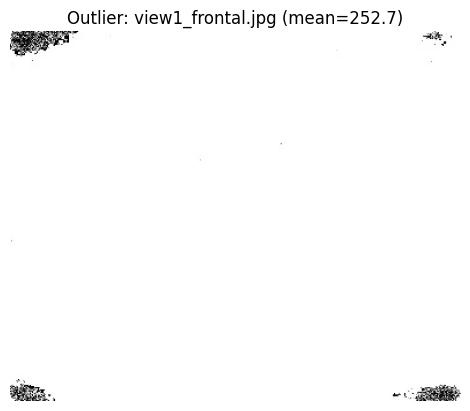

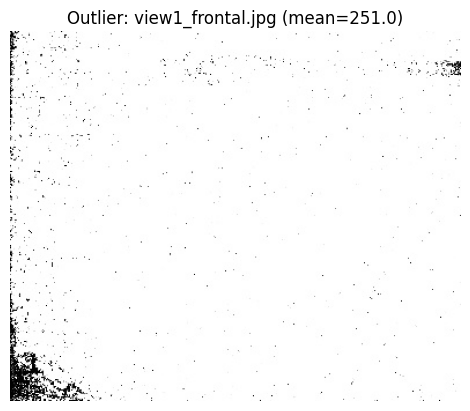

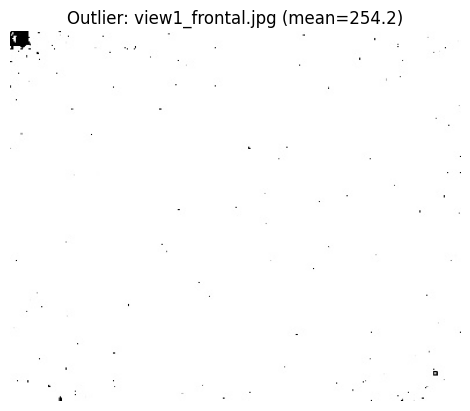

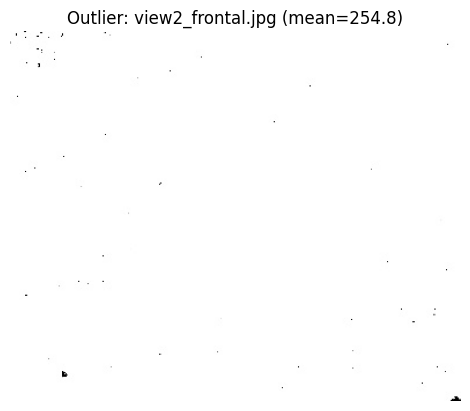

Jumlah gambar outlier yang disalin: 4


In [17]:
import os
from PIL import Image
import shutil

# Buat direktori output jika belum ada
outlier_dir = "outlier_image"
os.makedirs(outlier_dir, exist_ok=True)

# Threshold rata-rata intensitas piksel (misal: >240 dianggap outlier)
intensity_threshold = 240

outlier_count = 0
for item in combined_df2:
    img_path = item['Path']
    try:
        img = Image.open(img_path).convert('L')  # grayscale
        mean_intensity = img.resize((32, 32)).getdata()
        mean_intensity = sum(mean_intensity) / len(mean_intensity)
        if mean_intensity >= intensity_threshold:
            shutil.copy(img_path, os.path.join(outlier_dir, os.path.basename(img_path)))
            outlier_count += 1
            # Tampilkan gambar outlier
            import matplotlib.pyplot as plt
            plt.imshow(img, cmap='gray')
            plt.title(f"Outlier: {os.path.basename(img_path)} (mean={mean_intensity:.1f})")
            plt.axis('off')
            plt.show()
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

print(f"Jumlah gambar outlier yang disalin: {outlier_count}")

### split dataset

In [82]:
from sklearn.model_selection import train_test_split

# Split combined_df menjadi train (60%), validasi (20%), test (20%)
# Split combined_df2 (list of dict) menjadi train/valid/test dengan proporsi 60/20/20

train_df, temp_df = train_test_split(combined_df2, test_size=0.4, random_state=42, shuffle=True)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

# Untuk konsistensi dengan variabel sebelumnya, hapus variabel list sementara
del combined_df2
del temp_df

print(f"train_df shape: {len(train_df)}") #60
print(f"valid_df shape: {len(valid_df)}") #20
print(f"test_df shape: {len(test_df)}") #20

train_df shape: 81872
valid_df shape: 27291
test_df shape: 27291


### balancing data


Rasio Imbalance: 1.36


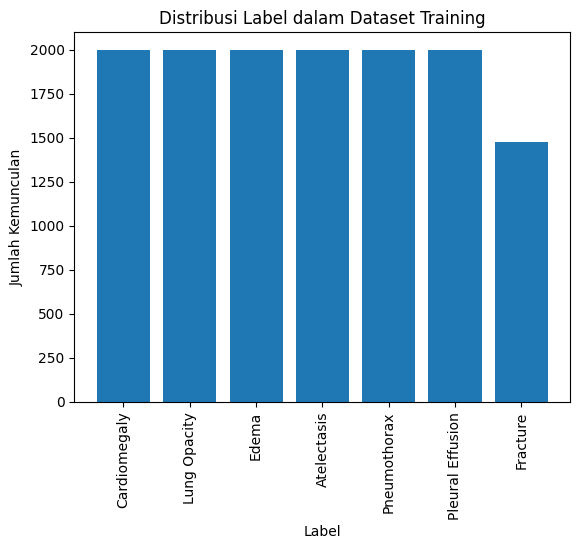


Rasio Imbalance: 1.80


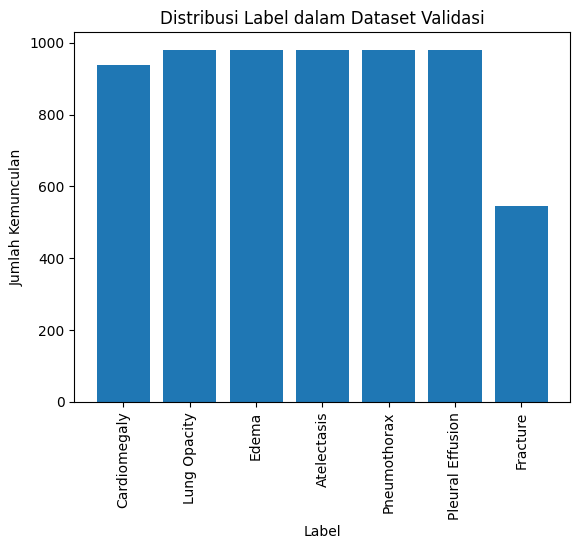

In [83]:
import random

def balance_multilabel_list(data_list, label_columns, max_per_label=10000, random_state=42):
    # Inisialisasi penghitung label
    label_counter = {label: 0 for label in label_columns}
    balanced_data = []

    # Shuffle dataset untuk menghindari urutan bias
    random.seed(random_state)
    shuffled = data_list.copy()
    random.shuffle(shuffled)

    for item in shuffled:
        labels = [label for label in item['Labels'] if label in label_columns]
        if all(label_counter[label] < max_per_label for label in labels):
            balanced_data.append(item)
            for label in labels:
                label_counter[label] += 1
        if all(count >= max_per_label for count in label_counter.values()):
            break

    return balanced_data

# Gunakan fungsi balancing
train_df = balance_multilabel_list(train_df, label_columns=label_cols, max_per_label=2000)
valid_df = balance_multilabel_list(valid_df, label_columns=label_cols, max_per_label=980)

# Hitung distribusi label
def multilabel_counts(data_list, label_columns):
    counts = {label: 0 for label in label_columns}
    for item in data_list:
        for label in item['Labels']:
            if label in counts:
                counts[label] += 1
    return counts

import matplotlib.pyplot as plt

train_label_counts = multilabel_counts(train_df, label_cols)
valid_label_counts = multilabel_counts(valid_df, label_cols)

import numpy as np
print(f"\nRasio Imbalance: {max(train_label_counts.values()) / max(1, min(train_label_counts.values())):.2f}")
plt.bar(train_label_counts.keys(), train_label_counts.values())
plt.title('Distribusi Label dalam Dataset Training')
plt.ylabel('Jumlah Kemunculan')
plt.xlabel('Label')
plt.xticks(rotation=90)
plt.show()

print(f"\nRasio Imbalance: {max(valid_label_counts.values()) / max(1, min(valid_label_counts.values())):.2f}")
plt.bar(valid_label_counts.keys(), valid_label_counts.values())
plt.title('Distribusi Label dalam Dataset Validasi')
plt.ylabel('Jumlah Kemunculan')
plt.xlabel('Label')
plt.xticks(rotation=90)
plt.show()

## Hasil Pre-procesing

In [84]:
train_df


[{'Path': 'CheXpert-v1.0-small/train/patient32012/study5/view1_frontal.jpg',
  'Labels': ['Lung Opacity']},
 {'Path': 'CheXpert-v1.0-small/train/patient37943/study9/view1_frontal.jpg',
  'Labels': ['Edema', 'Atelectasis']},
 {'Path': 'CheXpert-v1.0-small/train/patient54287/study1/view1_frontal.jpg',
  'Labels': []},
 {'Path': 'CheXpert-v1.0-small/train/patient04359/study1/view1_frontal.jpg',
  'Labels': ['Lung Opacity', 'Atelectasis']},
 {'Path': 'CheXpert-v1.0-small/train/patient01222/study7/view1_frontal.jpg',
  'Labels': ['Lung Opacity', 'Edema', 'Pleural Effusion']},
 {'Path': 'CheXpert-v1.0-small/train/patient30910/study5/view1_frontal.jpg',
  'Labels': ['Lung Opacity', 'Edema', 'Atelectasis', 'Pleural Effusion']},
 {'Path': 'CheXpert-v1.0-small/train/patient37738/study2/view1_frontal.jpg',
  'Labels': ['Lung Opacity', 'Pleural Effusion']},
 {'Path': 'CheXpert-v1.0-small/train/patient32347/study1/view1_frontal.jpg',
  'Labels': ['Fracture']},
 {'Path': 'CheXpert-v1.0-small/train/p

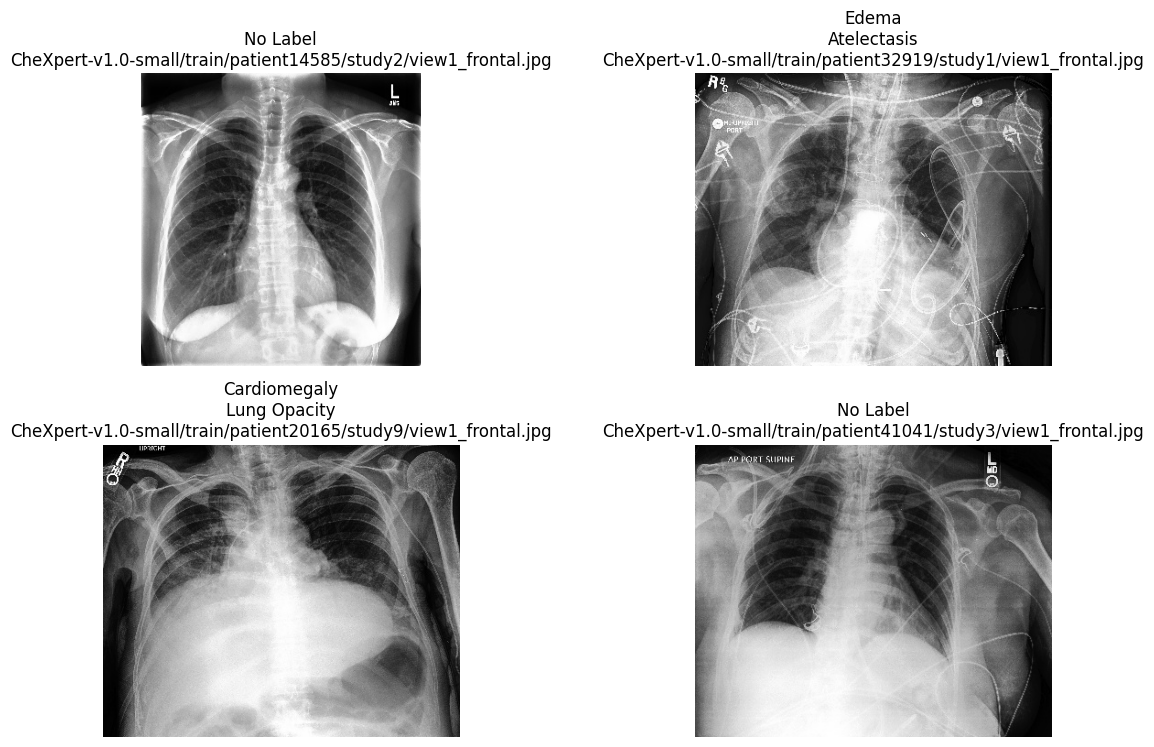

In [85]:
import random
from PIL import Image

import matplotlib.pyplot as plt

# Pilih sampel acak dari valid_df
samples = random.sample(train_df, 4)

plt.figure(figsize=(12, 15))
for i, sample in enumerate(samples):
    img_path = sample['Path']
    image = Image.open(img_path).convert('RGB')
    plt.subplot(4, 2, i+1)
    plt.imshow(image)
    plt.axis('off')
    title = ('\n'.join(sample['Labels']) if sample['Labels'] else 'No Label') + f"\n{sample['Path']}"
    plt.title(title)
plt.tight_layout()
plt.show()

## PROCESING

### Persiapan Label dan Dataset

In [86]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

# Membuat mapping label ke index dan sebaliknya
label2id = {label: i for i, label in enumerate(label_cols)}
id2label = {i: label for label, i in label2id.items()}

# Custom Dataset untuk CheXpert multilabel
class CheXpertDataset(Dataset):
    def __init__(self, dataframe, transform, label2id):
        # dataframe: list of dict {'Path': ..., 'Labels': [...]}
        self.data = list(dataframe)
        self.transform = transform
        self.label2id = label2id

    def __len__(self):
        # Mengembalikan jumlah data
        return len(self.data)

    def __getitem__(self, idx):
        # Ambil path gambar dan label
        image_path = self.data[idx]['Path']
        findings = self.data[idx]['Labels']
        image = Image.open(image_path).convert("RGB")

        # Membuat vektor biner multilabel
        label_vec = torch.zeros(len(self.label2id))
        for finding in findings:
            if finding in self.label2id:
                label_vec[self.label2id[finding]] = 1.0

        # Transformasi gambar jika ada
        if self.transform:
            image = self.transform(image)

        # Kembalikan dictionary sesuai kebutuhan Trainer HuggingFace
        return {"Path": image, "Labels": label_vec}


### Image Processor dan Tokenizer

In [87]:
from transformers import AutoImageProcessor, ViTForImageClassification

model_name = "WinKawaks/vit-small-patch16-224"
processor = AutoImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    problem_type="multi_label_classification",
    ignore_mismatched_sizes=True  # This will ignore the classifier head size mismatch
)

def collate_fn(batch):
    pixel_values = torch.stack([item["Path"] for item in batch])
    labels = torch.stack([item["Labels"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([7, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Transformasi Dataset

In [88]:
from torchvision import transforms

# Crop tengah dengan hitungan persen (misal: crop 90% area tengah)
class CenterCropPercent:
    def __init__(self, percent):
        self.percent = percent

    def __call__(self, img):
        w, h = img.size
        crop_w, crop_h = int(w * self.percent), int(h * self.percent)
        left = (w - crop_w) // 2
        top = (h - crop_h) // 2
        right = left + crop_w
        bottom = top + crop_h
        return img.crop((left, top, right, bottom))

# Contoh: crop 90% area tengah
train_transform = transforms.Compose([
    CenterCropPercent(0.7),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

lung_datasets = {
    "train": CheXpertDataset(train_df, train_transform, label2id),
    "validation": CheXpertDataset(valid_df, train_transform, label2id)
}


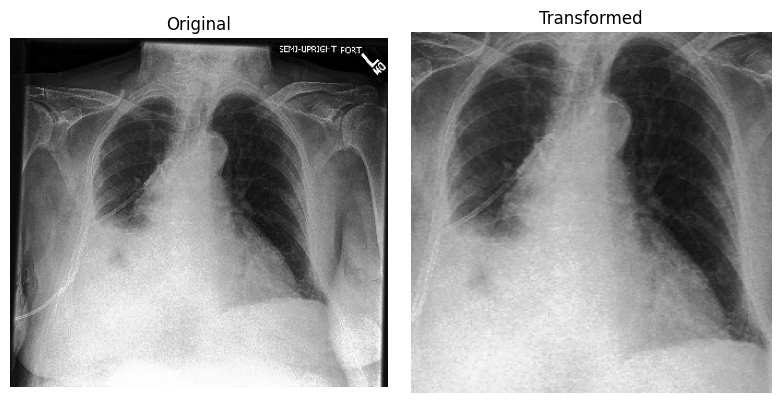

In [89]:
import numpy as np

# Preview hasil transformasi pada satu gambar dari train_df
import matplotlib.pyplot as plt

sample = train_df[0]
img_path = sample['Path']
original_image = Image.open(img_path).convert("RGB")
transformed_image = train_transform(original_image)

# Convert tensor to numpy for visualization
def tensor_to_image(tensor):
    img = tensor.clone().detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # CHW to HWC
    img = img * np.array(processor.image_std) + np.array(processor.image_mean)  # unnormalize
    img = np.clip(img, 0, 1)
    return img

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(transformed_image))
plt.title("Transformed")
plt.axis('off')
plt.tight_layout()
plt.show()

In [90]:
from sklearn.metrics import f1_score
import numpy as np
import torch

def compute_metrics(pred):
    logits, labels = pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)
    labels = labels.astype(int)

    micro_f1 = f1_score(labels, preds, average="micro")
    macro_f1 = f1_score(labels, preds, average="macro")

    return {
        "micro_f1": micro_f1,
        "macro_f1": macro_f1
    }


### Training

In [92]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Nama metrik yang digunakan untuk memilih model terbaik
metric_name = "micro_f1"

# Inisialisasi TrainingArguments untuk konfigurasi pelatihan
args = TrainingArguments(
    output_dir="chexpert-vit-model",        # Direktori output untuk menyimpan model
    eval_strategy="epoch",                  # Evaluasi dilakukan setiap beberapa langkah
    save_strategy="epoch",                  # Model disimpan setiap beberapa langkah
    logging_strategy="epoch",
    #logging_steps=100,                      # Logging setiap 100 langkah
    #save_steps=100,                         # Simpan model setiap 100 langkah
    #eval_steps=100,                         # Evaluasi setiap 100 langkah
    learning_rate=1e-5,                     #earning rate
    lr_scheduler_type="linear",             # atau linear, polynomial, dll
    #warmup_steps=500,                       # opsional: jumlah langkah warmup
    per_device_train_batch_size=16,          # Batch size untuk training per device
    per_device_eval_batch_size=16,           # Batch size untuk evaluasi per device
    num_train_epochs=50,                     # Jumlah epoch training
    weight_decay=0.01,                      # Weight decay (regularisasi)
    load_best_model_at_end=True,            # Muat model terbaik di akhir training
    metric_for_best_model=metric_name,      # Metrik yang digunakan untuk memilih model terbaik
    logging_dir='logs',                     # Direktori untuk menyimpan log
    remove_unused_columns=False,            # Jangan hapus kolom yang tidak digunakan
    push_to_hub=False,                      # Tidak mengunggah ke Hugging Face Hub
    # hub_model_id="chexpert-vit-multilabel"  # Nama model di Hugging Face Hub (tidak digunakan karena push_to_hub=False)
)

# Inisialisasi Trainer dari HuggingFace
trainer = Trainer(
    model=model,                            # Model yang akan dilatih
    args=args,                              # Argument konfigurasi training
    train_dataset=lung_datasets['train'],   # Dataset training
    eval_dataset=lung_datasets['validation'],# Dataset validasi
    data_collator=collate_fn,               # Fungsi untuk menggabungkan batch data
    compute_metrics=compute_metrics,        # Fungsi untuk menghitung metrik evaluasi
    tokenizer=processor,                     # Image processor/tokenizer
    callbacks=[EarlyStoppingCallback(
        early_stopping_patience=10
        )]
)

# Mulai proses training
trainer.train()


/tmp/ipykernel_416/2580684274.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1
1,0.214800,0.251828,0.157084,0.131334
2,0.196800,0.250361,0.266714,0.224207


KeyboardInterrupt: 

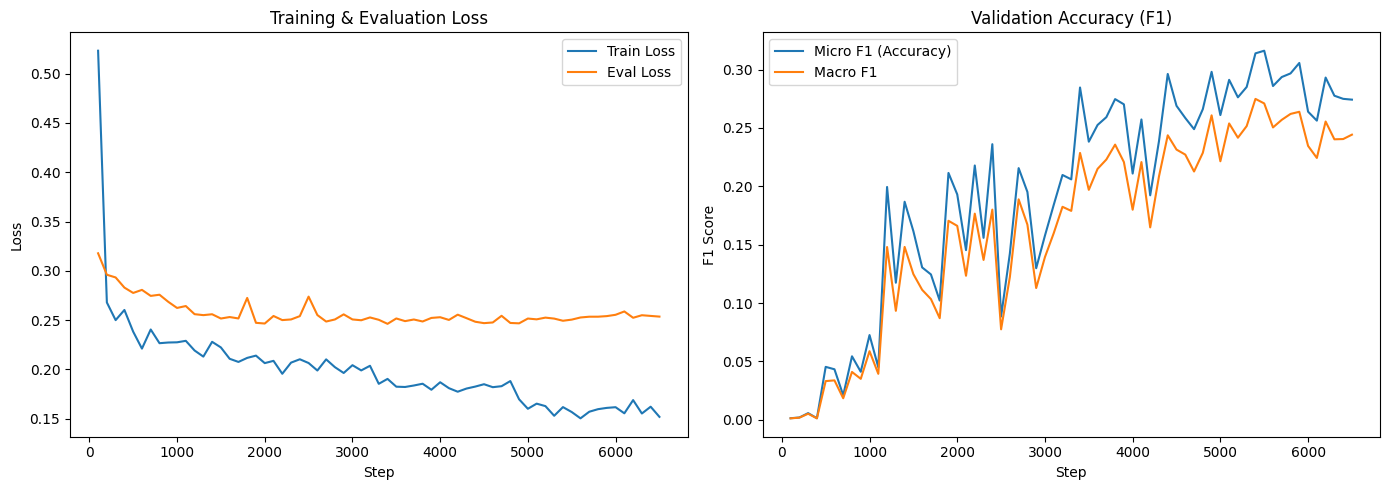

In [56]:
# Menampilkan plot loss dan accuracy dari hasil training HuggingFace Trainer

# Ambil data training log dari Trainer
training_logs = trainer.state.log_history

# Ekstrak loss dan f1 (accuracy) dari log
train_steps = []
train_loss = []
eval_steps = []
eval_loss = []
micro_f1 = []
macro_f1 = []

for log in training_logs:
    if 'loss' in log and 'step' in log:
        train_steps.append(log['step'])
        train_loss.append(log['loss'])
    if 'eval_loss' in log and 'step' in log:
        eval_steps.append(log['step'])
        eval_loss.append(log['eval_loss'])
    if 'eval_micro_f1' in log and 'step' in log:
        micro_f1.append(log['eval_micro_f1'])
    if 'eval_macro_f1' in log and 'step' in log:
        macro_f1.append(log['eval_macro_f1'])

plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Train Loss')
plt.plot(eval_steps, eval_loss, label='Eval Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Evaluation Loss')
plt.legend()

# Plot F1 score
plt.subplot(1, 2, 2)
plt.plot(eval_steps, micro_f1, label='Micro F1 (Accuracy)')
plt.plot(eval_steps, macro_f1, label='Macro F1')
plt.xlabel('Step')
plt.ylabel('F1 Score')
plt.title('Validation Accuracy (F1)')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
from torchvision import transforms
import torch
from PIL import Image

# Siapkan transformasi sesuai training
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

def predict_image(image_path, model, transform, label2id, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Tambahkan batch dimensi
    device = next(model.parameters()).device
    image = image.to(device)
    with torch.no_grad():
        outputs = model(image)
        logits = outputs.logits
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()
        pred_labels = [label for label, idx in label2id.items() if probs[idx] > threshold]
    return pred_labels, probs

# Contoh prediksi pada 5 data test_df
for sample in test_df[:5]:
    img_path = sample['Path']
    true_labels = sample['Labels']
    pred_labels, probs = predict_image(img_path, model, test_transform, label2id)
    print(f"Image: {img_path}")
    print(f"True Labels: {true_labels}")
    print(f"Predicted Labels: {pred_labels}")
    print(f"Probabilities: {probs}")
    print('-'*50)

Image: CheXpert-v1.0-small/train/patient01263/study5/view1_frontal.jpg
True Labels: ['Lung Opacity', 'Edema', 'Pleural Effusion']
Predicted Labels: ['Pleural Effusion']
Probabilities: [0.19131754 0.45358804 0.48022342 0.08985782 0.05957497 0.6041185
 0.01987262]
--------------------------------------------------
Image: CheXpert-v1.0-small/train/patient48720/study3/view1_frontal.jpg
True Labels: ['Atelectasis']
Predicted Labels: []
Probabilities: [0.01051393 0.02448513 0.00680307 0.08567039 0.27425653 0.01511319
 0.04485063]
--------------------------------------------------
Image: CheXpert-v1.0-small/train/patient16882/study2/view1_frontal.jpg
True Labels: ['Lung Opacity', 'Pleural Effusion']
Predicted Labels: []
Probabilities: [0.30057472 0.02972375 0.04486196 0.042721   0.03659001 0.05535145
 0.09727339]
--------------------------------------------------
Image: CheXpert-v1.0-small/train/patient39596/study4/view1_frontal.jpg
True Labels: ['Pneumothorax']
Predicted Labels: ['Pneumothor

# **HIDUP JOKOWI ! ✊** 